# AquaCrop Ottawa Reference Simulation
This notebook uses exact data from the reference file to simulate alfalfa growth in Ottawa.

## Install

In [1]:
%pip install pyaquacrop

Note: you may need to restart the kernel to use updated packages.


## Import Required Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime

# Import AquaCrop classes
from aquacrop import AquaCrop, Crop, Soil, SoilLayer, Weather, FieldManagement, Observation, Parameter
from aquacrop.templates import (
    ottawa_temperatures, ottawa_rain, 
    ottawa_eto
)

Loaded data sizes: Temperatures=1096, ETo=1096, Rain=1096


## Define Simulation Dates
Setup simulation dates to match the Ottawa reference for multiple years

In [3]:
# Define simulation dates to match Ottawa reference for Year 1
# Based on Ottawa.PRM file: 


simulation_periods = [
    {
            # Year 1:
            # First day: 41414 (21 May 2014)
            # Last day: 41577 (31 October 2014)
            # Planting: 41414 (21 May 2014)
            "start_date": date(2014, 5, 21),
            "end_date": date(2014, 10, 31),
            "planting_date": date(2014, 5, 21),
            "is_seeding_year": True,
        },
    {
 

        # First day: 41578 (01 November 2014)
        # Last day: 41935 (24 October 2015)
        # Planting: 41759 (01 May 2015)
        'start_date': date(2014, 11, 1),
        'end_date': date(2015, 10, 24),
        'planting_date': date(2015, 5, 1),
        'is_seeding_year': True
    },
    {
        # Year 3:
        # First day: 41936 (25 October 2015)
        # Last day: 42305 (28 October 2016)
        # Planting: 42131 (07 May 2016)
        'start_date': date(2015, 10, 25),
        'end_date': date(2016, 10, 28),
        'planting_date': date(2016, 5, 7),
        'is_seeding_year': False
    }
]

# Set up working directory for outputs
output_dir = "outputs/basic_simulation"
os.makedirs(output_dir, exist_ok=True)

## Create Soil Entity
Define soil parameters to match Ottawa reference soil

In [4]:
# Create soil entity to match Ottawa reference soil parameters
soil = Soil(
    name="Ottawa",
    description="Ottawa, Canada - sandy loam - Field of the Canadian Food Inspection Agency (CFIA)",
    soil_layers=[
        SoilLayer(
            thickness=1.50,
            sat=46.0,
            fc=29.0,
            wp=13.0,
            ksat=1200.0,
            penetrability=100,
            gravel=0,
            cra=-0.390600,
            crb=1.255639,
            description="sandy loam"
        )
    ],
    curve_number=46,
    readily_evaporable_water=7
)

## Create Crop Entity
Define alfalfa crop parameters for Ottawa

In [5]:
# Create crop entity to match reference crop file
crop = Crop(
    name="AlfOttawaGDD",
    description="Ottawa variety - Alfalfa - Louvain-La-Neuve (Belgium) -  adjusted for Ottawa - calibrated for Soil Fertility",
    params={
        # Basic classifications
        'crop_type': 4,  # forage crop
        'is_sown': True,
        'cycle_determination': 0,  # by growing degree-days
        'adjust_for_eto': True,
        
        # Temperature parameters
        'base_temp': 5.0,
        'upper_temp': 30.0,
        'gdd_cycle_length': 1920,
        'dormancy_eto_threshold': 600,
        
        # Crop water stress parameters
        'p_upper_canopy': 0.15,
        'p_lower_canopy': 0.55,
        'shape_canopy': 3.0,
        'p_upper_stomata': 0.60,
        'shape_stomata': 3.0,
        'p_upper_senescence': 0.70,
        'shape_senescence': 3.0,
        'p_upper_pollination': 0.90,
        'aeration_stress_threshold': 2,
        
        # Soil fertility stress parameters
        'fertility_stress_calibration': 50,
        'shape_fertility_canopy_expansion': 2.35,
        'shape_fertility_max_canopy': 0.79,
        'shape_fertility_water_productivity': -0.16,
        'shape_fertility_decline': 6.26,
        
        # Temperature stress parameters
        'cold_stress_for_pollination': 8,
        'heat_stress_for_pollination': 40,
        'minimum_growing_degrees_pollination': 8.0,
        
        # Salinity stress parameters
        'salinity_threshold_ece': 2,
        'salinity_max_ece': 16,
        'salinity_shape_factor': -9,
        'salinity_stress_cc': 25,
        'salinity_stress_stomata': 100,
        
        # Transpiration parameters
        'kc_max': 1.15,
        'kc_decline': 0.050,
        
        # Rooting parameters
        'min_rooting_depth': 0.30,
        'max_rooting_depth': 3.00,
        'root_expansion_shape': 15,
        'max_water_extraction_top': 0.020,
        'max_water_extraction_bottom': 0.010,
        'soil_evaporation_reduction': 60,
        
        # Canopy development parameters
        'canopy_cover_per_seedling': 2.50,
        'canopy_regrowth_size': 19.38,
        'plant_density': 2000000,
        'max_canopy_cover': 0.95,
        'canopy_growth_coefficient': 0.17713,
        'canopy_thinning_years': 9,
        'canopy_thinning_shape': 0.50,
        'canopy_decline_coefficient': 0.03636,
        
        # Crop cycle parameters (Calendar days)
        'days_emergence': 2,
        'days_max_rooting': 178,
        'days_senescence': 180,
        'days_maturity': 180,
        'days_flowering': 0,
        'days_flowering_length': 0,
        'days_crop_determinancy': 0,
        'days_hi_start': 17,
        
        # Crop cycle parameters (Growing degree days)
        'gdd_emergence': 5,
        'gdd_max_rooting': 1920,
        'gdd_senescence': 1920,
        'gdd_maturity': 1920,
        'gdd_flowering': 0,
        'gdd_flowering_length': 0,
        'cgc_gdd': 0.012,
        'cdc_gdd': 0.006,
        'gdd_hi_start': 118,
        
        # Biomass and yield parameters
        'water_productivity': 15.0,
        'water_productivity_yield_formation': 100,
        'co2_response_strength': 50,
        'harvest_index': 1.00,
        'water_stress_hi_increase': -9,
        'veg_growth_impact_hi': -9.0,
        'stomatal_closure_impact_hi': -9.0,
        'max_hi_increase': -9,
        'dry_matter_content': 20,
        
        # Perennial crop parameters
        'is_perennial': True,
        'first_year_min_rooting': 0.30,
        'assimilate_transfer': 1,
        'assimilate_storage_days': 100,
        'assimilate_transfer_percent': 65,
        'root_to_shoot_transfer_percent': 60,
        
        # Crop calendar for perennials
        'restart_type': 13,
        'restart_window_day': 1,
        'restart_window_month': 4,
        'restart_window_length': 120,
        'restart_gdd_threshold': 20.0,
        'restart_days_required': 8,
        'restart_occurrences': 2,
        'end_type': 63,
        'end_window_day': 31,
        'end_window_month': 10,
        'end_window_years_offset': 0,
        'end_window_length': 60,
        'end_gdd_threshold': 10.0,
        'end_days_required': 8,
        'end_occurrences': 1
    }
)

## Define CO2 Concentration Records
CO2 values over time for simulation

In [7]:
# Define CO2 concentration records (matching reference CO2 file)
co2_records = [
    (1902, 297.4), (1905, 298.2), (1912, 300.7), (1915, 301.3), (1924, 304.5),
    (1926, 305.0), (1929, 305.2), (1932, 307.8), (1934, 309.2), (1936, 307.9),
    (1938, 310.5), (1939, 310.1), (1940, 310.5), (1944, 309.7), (1948, 310.7),
    (1953, 311.9), (1954, 314.1), (1958, 315.29), (1959, 315.98), (1960, 316.91),
    (1961, 317.64), (1962, 318.45), (1963, 318.99), (1964, 319.62), (1965, 320.04),
    (1966, 321.37), (1967, 322.18), (1968, 323.05), (1969, 324.62), (1970, 325.68),
    (1971, 326.32), (1972, 327.46), (1973, 329.68), (1974, 330.19), (1975, 331.12),
    (1976, 332.03), (1977, 333.84), (1978, 335.41), (1979, 336.84), (1980, 338.76),
    (1981, 340.12), (1982, 341.48), (1983, 343.15), (1984, 344.85), (1985, 346.35),
    (1986, 347.61), (1987, 349.31), (1988, 351.69), (1989, 353.2), (1990, 354.45),
    (1991, 355.7), (1992, 356.54), (1993, 357.21), (1994, 358.96), (1995, 360.97),
    (1996, 362.74), (1997, 363.88), (1998, 366.84), (1999, 368.54), (2000, 369.71),
    (2001, 371.32), (2002, 373.45), (2003, 375.98), (2004, 377.7), (2005, 379.98),
    (2006, 382.09), (2007, 384.02), (2008, 385.83), (2009, 387.64), (2010, 390.1),
    (2011, 391.85), (2012, 394.06), (2013, 396.74), (2014, 398.82), (2015, 401.02),
    (2016, 404.41), (2017, 406.77), (2018, 408.72), (2019, 411.66), (2020, 414.21),
    (2021, 416.41), (2022, 418.53), (2023, 421.08), (2025, 425.08), (2099, 573.08)
]

## Load Weather Data and Create Weather Entity

In [8]:

# Create weather entity using the loaded data
climate = Weather(
    location="Ottawa",
    temperatures=ottawa_temperatures,
    eto_values=ottawa_eto,
    rainfall_values=ottawa_rain,
    record_type=1,  # Daily records
    first_day=1,
    first_month=1, 
    first_year=2014,
    co2_records=co2_records
)

## Create Field Management Entity

In [9]:
# Create management entity to match the reference management file
management = FieldManagement(
    name="Ottawa",
    description="Ottawa, Canada",
    params={
        'fertility_stress': 50,
        'mulch_cover': 0,
        'mulch_effect': 50,
        'bund_height': 0.00,
        'surface_runoff_affected': 0,
        'runoff_adjustment': 0,
        'weed_cover_initial': 0,
        'weed_cover_increase': 0,
        'weed_shape_factor': 100.00,
        'weed_replacement': 100,
        'multiple_cuttings': True,
        'canopy_after_cutting': 25,
        'cgc_increase_after_cutting': 20,
        'cutting_window_start_day': 1,
        'cutting_window_length': -9,
        'cutting_schedule_type': 0,
        'cutting_time_criterion': 0,
        'final_harvest_at_maturity': 0,
        'day_nr_base': 41274,
        'harvest_days': [194, 243, 536, 572, 607, 897, 932, 972]
    }
)

## Create Observation Entity
Using field measurements for validation

In [10]:
# Create observation entity with exactly the provided data
observations = [
    {'day': 144, 'canopy_cover': (-9.0, -9.0), 'biomass': (0.045, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 160, 'canopy_cover': (-9.0, -9.0), 'biomass': (0.386, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 169, 'canopy_cover': (-9.0, -9.0), 'biomass': (1.039, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 176, 'canopy_cover': (-9.0, -9.0), 'biomass': (1.217, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 184, 'canopy_cover': (-9.0, -9.0), 'biomass': (2.390, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 191, 'canopy_cover': (-9.0, -9.0), 'biomass': (3.191, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 194, 'canopy_cover': (-9.0, -9.0), 'biomass': (3.606, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 196, 'canopy_cover': (-9.0, -9.0), 'biomass': (3.947, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 205, 'canopy_cover': (-9.0, -9.0), 'biomass': (4.407, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 211, 'canopy_cover': (-9.0, -9.0), 'biomass': (4.853, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 219, 'canopy_cover': (-9.0, -9.0), 'biomass': (6.189, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 226, 'canopy_cover': (-9.0, -9.0), 'biomass': (6.263, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 230, 'canopy_cover': (-9.0, -9.0), 'biomass': (6.901, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 236, 'canopy_cover': (-9.0, -9.0), 'biomass': (7.168, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 243, 'canopy_cover': (-9.0, -9.0), 'biomass': (7.242, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 482, 'canopy_cover': (-9.0, -9.0), 'biomass': (0.792, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 488, 'canopy_cover': (-9.0, -9.0), 'biomass': (0.985, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 498, 'canopy_cover': (-9.0, -9.0), 'biomass': (1.995, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 505, 'canopy_cover': (-9.0, -9.0), 'biomass': (2.649, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 517, 'canopy_cover': (-9.0, -9.0), 'biomass': (4.164, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 525, 'canopy_cover': (-9.0, -9.0), 'biomass': (5.234, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 530, 'canopy_cover': (-9.0, -9.0), 'biomass': (5.219, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 536, 'canopy_cover': (-9.0, -9.0), 'biomass': (5.220, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 537, 'canopy_cover': (-9.0, -9.0), 'biomass': (5.242, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 551, 'canopy_cover': (-9.0, -9.0), 'biomass': (7.043, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 558, 'canopy_cover': (-9.0, -9.0), 'biomass': (7.830, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 572, 'canopy_cover': (-9.0, -9.0), 'biomass': (8.796, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 573, 'canopy_cover': (-9.0, -9.0), 'biomass': (9.122, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 587, 'canopy_cover': (-9.0, -9.0), 'biomass': (10.400, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 594, 'canopy_cover': (-9.0, -9.0), 'biomass': (11.010, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 876, 'canopy_cover': (-9.0, -9.0), 'biomass': (2.678, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 883, 'canopy_cover': (-9.0, -9.0), 'biomass': (3.628, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 891, 'canopy_cover': (-9.0, -9.0), 'biomass': (5.054, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 897, 'canopy_cover': (-9.0, -9.0), 'biomass': (4.817, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 898, 'canopy_cover': (-9.0, -9.0), 'biomass': (5.181, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 910, 'canopy_cover': (-9.0, -9.0), 'biomass': (5.435, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 917, 'canopy_cover': (-9.0, -9.0), 'biomass': (6.222, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 924, 'canopy_cover': (-9.0, -9.0), 'biomass': (6.609, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 932, 'canopy_cover': (-9.0, -9.0), 'biomass': (7.811, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 933, 'canopy_cover': (-9.0, -9.0), 'biomass': (8.149, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 945, 'canopy_cover': (-9.0, -9.0), 'biomass': (8.729, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 953, 'canopy_cover': (-9.0, -9.0), 'biomass': (9.086, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 959, 'canopy_cover': (-9.0, -9.0), 'biomass': (9.502, -9.0), 'soil_water': (-9.0, -9.0)},
    {'day': 964, 'canopy_cover': (-9.0, -9.0), 'biomass': (10.304, -9.0), 'soil_water': (-9.0, -9.0)}
]

# Create the observation entity
observation = Observation(
    name="Ottawa",
    location="Ottawa, Canada",
    observations=observations,
    soil_depth=1.0,
    first_day=1,
    first_month=1,
    first_year=2014
)

## Create Parameter Entity

In [11]:
# Create parameter entity to match reference parameter file
parameter = Parameter(
    name="Ottawa",
    params={
        'evaporation_decline_factor': 4,
        'kex': 1.10,
        'cc_threshold_for_hi': 5,
        'root_expansion_start_depth': 70,
        'max_root_expansion': 5.00,
        'shape_root_water_stress': -6,
        'germination_soil_water': 20,
        'fao_adjustment_factor': 1.0,
        'aeration_days': 3,
        'senescence_factor': 1.00,
        'senescence_reduction': 12,
        'top_soil_thickness': 10,
        'evaporation_depth': 30,
        'cn_depth': 0.30,
        'cn_adjustment': 1,
        'salt_diffusion_factor': 20,
        'salt_solubility': 100,
        'soil_water_gradient_factor': 16,
        'default_min_temp': 12.0,
        'default_max_temp': 28.0,
        'gdd_method': 3,
        'rainfall_estimation': 1,
        'effective_rainfall_pct': 70,
        'showers_per_decade': 2,
        'soil_evaporation_reduction': 5
    }
)

## Create and Run AquaCrop Simulation
Set up and execute the simulation

In [12]:
# Create AquaCrop simulation with all components
simulation = AquaCrop(
    simulation_periods=simulation_periods,
    crop=crop,
    soil=soil,
    irrigation=None,  # No irrigation file specified in reference
    management=management,
    climate=climate,
    observation=observation,
    parameter=parameter,
    working_dir=output_dir,
    need_daily_output=True,
    need_seasonal_output=True,
    need_harvest_output=True,
    need_evaluation_output=True
)

# Run the simulation
print("Running AquaCrop simulation...")
results = simulation.run()
daily_results = results['day']

# Save results
results_dir = os.path.join(output_dir, "results")
simulation.save_results(results_dir)
print(f"Simulation results saved to: {results_dir}")

Running AquaCrop simulation...
Setting up working directory at: /Users/franciscopuigperez-barquero/projects/aquacrop-py/docs/notebooks/outputs/basic_simulation
Running AquaCrop simulation with project file: /Users/franciscopuigperez-barquero/projects/aquacrop-py/docs/notebooks/outputs/basic_simulation/LIST/PROJECT.PRM
Detected platform: darwin (x86_64)
Looking for executable at: /Users/franciscopuigperez-barquero/projects/aquacrop-py/model/macOS/aquacrop
AquaCrop executable not found at /Users/franciscopuigperez-barquero/projects/aquacrop-py/model/macOS/aquacrop. Downloading from https://github.com/KUL-RSDA/AquaCrop/releases/download/v7.2/aquacrop-7.2-x86_64-macos.zip
Extracted AquaCrop executable to /Users/franciscopuigperez-barquero/projects/aquacrop-py/model/macOS/aquacrop-7.2-x86_64-macos/aquacrop
Using AquaCrop executable: /Users/franciscopuigperez-barquero/projects/aquacrop-py/docs/notebooks/outputs/basic_simulation/aquacrop
AquaCrop simulation completed successfully
Parsing simu

## View and Analyze Daily Results

In [13]:
# Assuming daily_results is the result from simulation.results['day']
if daily_results is not None:
    print("\nSimulation Summary:")
    
    # Check if daily_results is a dictionary (multiple runs) or DataFrame (single run)
    if isinstance(daily_results, dict):
        # Process each run
        for run_num, run_df in daily_results.items():
            print(f"\nRun {run_num}:")
            
            if 'Biomass' in run_df.columns:
                final_biomass = run_df['Biomass'].iloc[-1]
                print(f"  Final biomass: {final_biomass:.2f} ton/ha")
            
            if 'Y(dry)' in run_df.columns:
                final_yield = run_df['Y(dry)'].iloc[-1]
                print(f"  Final yield (dry): {final_yield:.2f} ton/ha")
            
            # Add other metrics as needed
    else:
        # Original code for single run
        if 'Biomass' in daily_results.columns:
            final_biomass = daily_results['Biomass'].iloc[-1]
            print(f"Final biomass: {final_biomass:.2f} ton/ha")
        
        if 'Y(dry)' in daily_results.columns:
            final_yield = daily_results['Y(dry)'].iloc[-1]
            print(f"Final yield (dry): {final_yield:.2f} ton/ha")


Simulation Summary:
Final biomass: 9.17 ton/ha
Final yield (dry): 9.01 ton/ha


Visualize CC over day-month-year

Saved chart to ./output_charts/canopy_cover_run_1.png


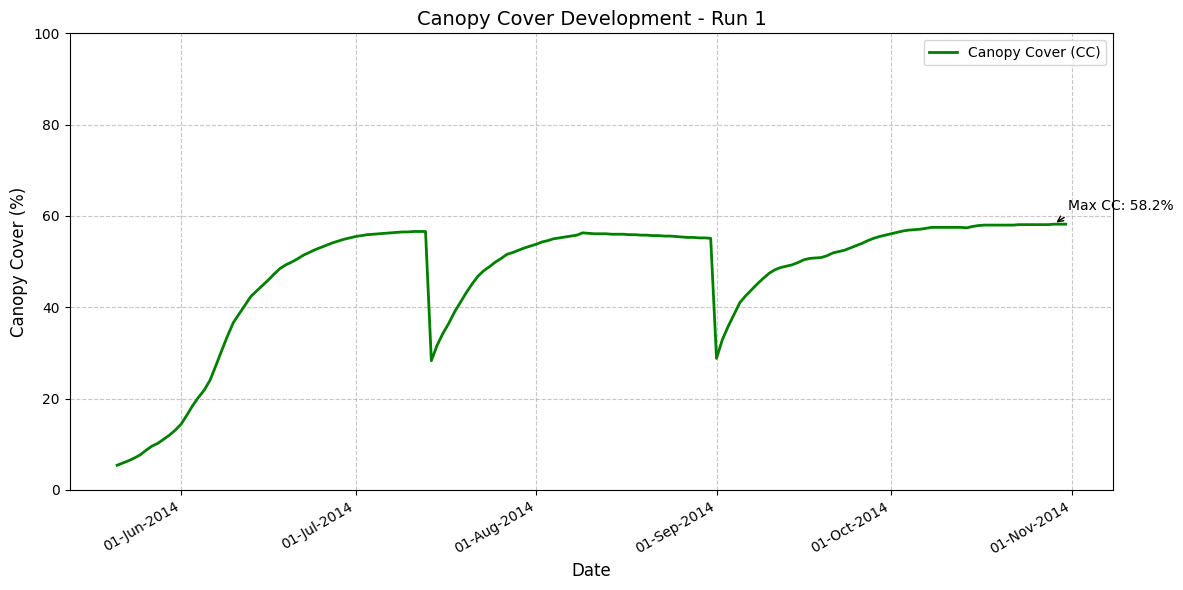

In [14]:
# Imports needed for visualization
import matplotlib.dates as mdates


# Set up output directory (optional - for saving charts)
output_dir = "./output_charts"
if output_dir and not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Determine if we have a dictionary (multiple runs) or a single DataFrame
if isinstance(daily_results, dict):
    run_dfs = daily_results
else:
    # Handle single DataFrame case
    run_dfs = {1: daily_results}

# Create plots for each run
for run_num, df in run_dfs.items():
    # Check if we have the required columns
    if 'CC' not in df.columns:
        print(f"Warning: Canopy Cover (CC) data not found in Run {run_num}")
        continue
        
    if not all(col in df.columns for col in ['Day', 'Month', 'Year']):
        print(f"Warning: Date columns (Day, Month, Year) not found in Run {run_num}")
        continue
    
    # Create datetime objects from Day, Month, Year columns
    dates = []
    for i in range(len(df)):
        try:
            day = int(df['Day'].iloc[i])
            month = int(df['Month'].iloc[i])
            year = int(df['Year'].iloc[i])
            dates.append(datetime(year, month, day))
        except (ValueError, TypeError):
            # Handle any invalid date values
            dates.append(None)
    
    # Filter out any None values
    valid_indices = [i for i, date in enumerate(dates) if date is not None]
    valid_dates = [dates[i] for i in valid_indices]
    cc_values = [df['CC'].iloc[i] for i in valid_indices]
    
    if not valid_dates:
        print(f"Warning: No valid dates found in Run {run_num}")
        continue
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the data
    ax.plot(valid_dates, cc_values, 'g-', linewidth=2)
    
    # Add grid and labels
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Canopy Cover (%)', fontsize=12)
    ax.set_title(f'Canopy Cover Development - Run {run_num}', fontsize=14)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    fig.autofmt_xdate()  # Rotate date labels for better readability
    
    # Set y-axis limits with padding
    if cc_values:
        max_cc = max(cc_values)
        ax.set_ylim([0, max(100, max_cc * 1.1)])  # Cap at 100% but allow higher if in data
    
    # Add annotations for key points
    if cc_values:
        max_cc_index = np.argmax(cc_values)
        max_cc_value = cc_values[max_cc_index]
        max_cc_date = valid_dates[max_cc_index]
        
        # Annotate maximum CC point
        ax.annotate(f'Max CC: {max_cc_value:.1f}%',
                    xy=(max_cc_date, max_cc_value),
                    xytext=(10, 10),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))
    
    # Add legend
    ax.legend(['Canopy Cover (CC)'], loc='upper right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure if output directory is provided
    if output_dir:
        fig_path = os.path.join(output_dir, f'canopy_cover_run_{run_num}.png')
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"Saved chart to {fig_path}")
    
    # Display the figure (useful in notebooks)
    plt.show()

## Visualize Simulation Results

In [15]:
# Create visualization plots
if daily_results is not None:
    # Check if daily_results is a dictionary (multiple runs) or DataFrame (single run)
    if isinstance(daily_results, dict):
        # Process each run or select a specific run
        
        for run_num, run_df in daily_results.items():
            plt.figure(figsize=(15, 12))
            plt.suptitle(f'Simulation Results - Run {run_num}', fontsize=16)
            
            # Create date labels for x-axis
            if 'Day' in run_df.columns and 'Month' in run_df.columns and 'Year' in run_df.columns:
                date_labels = [f"{int(run_df['Day'].iloc[i])}/{int(run_df['Month'].iloc[i])}/{int(run_df['Year'].iloc[i])}" 
                             for i in range(len(run_df))]
                # Use a subset of dates for tick labels to avoid overcrowding
                tick_indices = list(range(0, len(run_df), max(1, len(run_df) // 10)))
                tick_labels = [date_labels[i] for i in tick_indices]
            else:
                # Fallback if date columns aren't available
                date_labels = [i for i in range(len(run_df))]
                tick_indices = list(range(0, len(run_df), max(1, len(run_df) // 10)))
                tick_labels = [date_labels[i] for i in tick_indices]
            
            # Plot 1: Canopy Cover
            plt.subplot(3, 1, 1)
            if 'CC' in run_df.columns:
                plt.plot(range(len(run_df)), run_df['CC'], 'g-')
                plt.ylabel('Canopy Cover (%)')
                plt.title('Canopy Cover Development')
                plt.grid(True)
                plt.xticks(tick_indices, tick_labels, rotation=45)
            
            # Plot 2: Biomass
            plt.subplot(3, 1, 2)
            if 'Biomass' in run_df.columns:
                plt.plot(range(len(run_df)), run_df['Biomass'], 'b-')
                plt.ylabel('Biomass (ton/ha)')
                plt.title('Biomass Accumulation')
                plt.grid(True)
                plt.xticks(tick_indices, tick_labels, rotation=45)
            
            # Plot 3: Soil Water Content
            plt.subplot(3, 1, 3)
            water_content_column = next((col for col in run_df.columns if 'WC' in col or col == 'SWC'), None)
            if water_content_column:
                plt.plot(range(len(run_df)), run_df[water_content_column], 'r-')
                plt.xlabel('Date (Day/Month/Year)')
                plt.ylabel('Soil Water Content (mm)')
                plt.title('Soil Water Content')
                plt.grid(True)
                plt.xticks(tick_indices, tick_labels, rotation=45)
            
            plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
            plt.savefig(os.path.join(output_dir, f'simulation_results_run_{run_num}.png'))
            plt.show()

## View Seasonal and Harvest Results

In [16]:
# Display seasonal results
season_results = results['season']
if season_results is not None:
    print("\nSeasonal Results:")
    display(season_results)

# Display harvest results
harvest_results = results['harvests']
if harvest_results is not None:
    print("\nHarvest Results:")
    display(harvest_results)


Seasonal Results:


,RunNr,Day1,Month1,Year1,Rain,ETo,GD,CO2,Irri,Infilt,...,HI,Y(dry),Y(fresh),WPet,Bin,Bout,DayN,MonthN,YearN,Project
0,1,21,5,2014,487.5,431.0,1802.6,398.82,0.0,484.1,...,98.3,9.014,45.072,2.15,0.000,2.336,31,10,2014,PROJECT.PRM
1,2,1,11,2014,782.1,617.6,2118.6,401.02,0.0,777.8,...,100.0,11.947,59.737,2.47,0.280,2.306,24,10,2015,PROJECT.PRM
2,3,25,10,2015,926.2,653.7,2213.1,404.41,0.0,906.2,...,100.0,12.579,62.893,2.67,1.384,2.467,28,10,2016,PROJECT.PRM



Harvest Results:


,Nr,Day,Month,Year,DAP,Interval,Biomass,Sum(B),Dry-Yield,Sum(Y),Fresh-Yield,Sum(Y)
0,0,21,5,2014,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
1,1,13,7,2014,54.000,54.000,4.787,4.787,4.629,4.629,23.143,23.143
2,2,31,8,2014,103.000,49.000,3.082,7.869,3.082,7.711,15.409,38.553
3,9999,1,11,2014,9.172,9.014,45.072,NaN,NaN,NaN,NaN,NaN


## Visualize Harvest Results

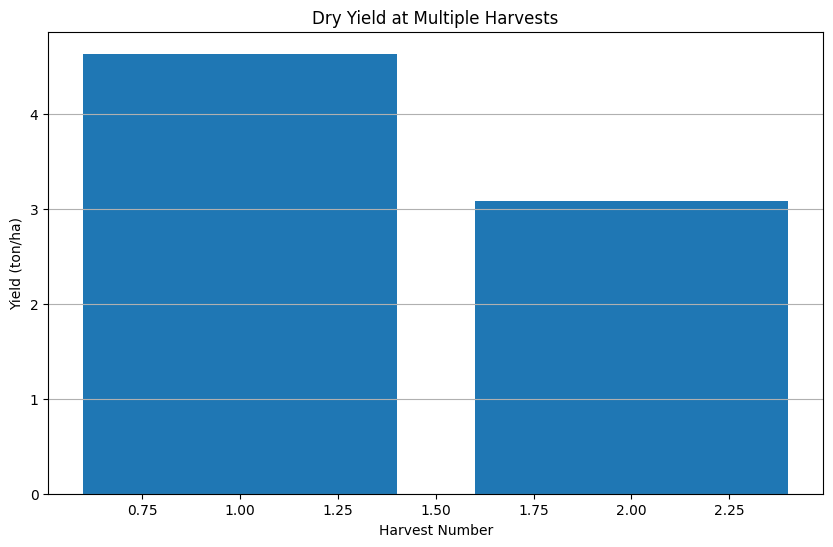

In [17]:
# Plot harvest results if available
if harvest_results is not None and isinstance(harvest_results, pd.DataFrame) and not harvest_results.empty:
    plt.figure(figsize=(10, 6))
    
    # Check if we have yield or biomass columns
    if 'Dry-Yield' in harvest_results.columns:
        plt.bar(harvest_results.index, harvest_results['Dry-Yield'])
        plt.title('Dry Yield at Multiple Harvests')
        plt.ylabel('Yield (ton/ha)')
    elif 'Biomass' in harvest_results.columns:
        plt.bar(harvest_results.index, harvest_results['Biomass'])
        plt.title('Biomass at Multiple Harvests')
        plt.ylabel('Biomass (ton/ha)')
        
    plt.xlabel('Harvest Number')
    plt.grid(True, axis='y')
    plt.savefig(os.path.join(output_dir, 'harvest_results.png'))
    plt.show()

## Compare Simulation Results with Observations

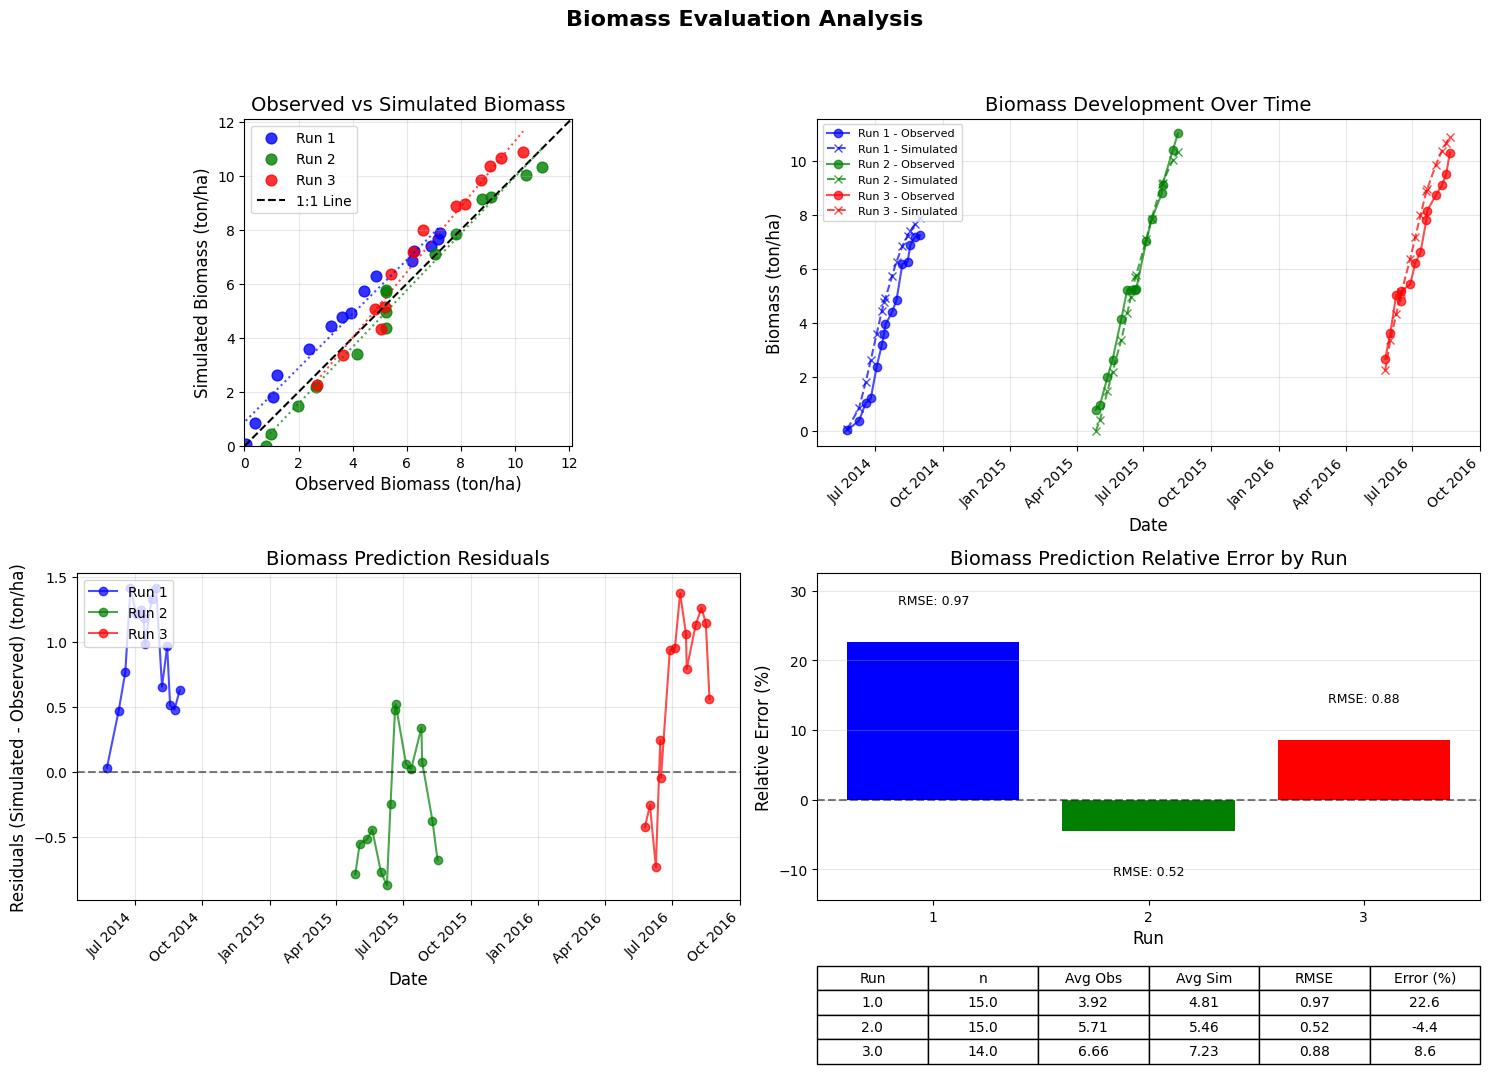


Biomass Evaluation Summary Statistics:
   Run   n  Avg Obs  Avg Sim  RMSE  Error (%)
0    1  15     3.92     4.81  0.97       22.6
1    2  15     5.71     5.46  0.52       -4.4
2    3  14     6.66     7.23  0.88        8.6


In [18]:

"""Create detailed visualizations for biomass evaluation data"""
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
evaluation_results_biomass = results.get('evaluation', {}).get('biomass', None)

# Check if evaluation_results_biomass is a dictionary or a DataFrame
if isinstance(evaluation_results_biomass, dict):
    # Combine all runs into a single DataFrame
    all_data = []
    for run, df in evaluation_results_biomass.items():
        if isinstance(df, pd.DataFrame) and not df.empty:
            # Add run number if not present
            if 'Run' not in df.columns:
                df['Run'] = run
            all_data.append(df)
    
    if all_data:
        df = pd.concat(all_data, ignore_index=True)
    else:
        print("No valid data found in evaluation_results_biomass")
else:
    # Already a DataFrame
    df = evaluation_results_biomass

# Check if DataFrame is empty
if df is None or df.empty:
    print("No biomass evaluation data available")

# Create datetime objects for better date handling
if all(col in df.columns for col in ['Day', 'Month', 'Year']):
    # Convert month names to numbers if needed
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
        'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    
    def parse_date(row):
        try:
            # Check if Month is a string (month name) or a number
            if isinstance(row['Month'], str):
                month = month_map.get(row['Month'], 1)  # Default to January if not found
            else:
                month = int(row['Month'])
            
            return datetime(int(row['Year']), month, int(row['Day']))
        except (ValueError, TypeError):
            # Return a default date if parsing fails
            return datetime(2000, 1, 1)
    
    df['DateTime'] = df.apply(parse_date, axis=1)
    # Sort by date
    df = df.sort_values(by='DateTime')

# Set up the figure and subplots
fig = plt.figure(figsize=(15, 12))
plt.suptitle('Biomass Evaluation Analysis', fontsize=16, weight='bold')

# 1. Scatter plot of Observed vs Simulated values
ax1 = plt.subplot(2, 2, 1)

# Extract unique runs
runs = df['Run'].unique() if 'Run' in df.columns else [1]

# Define colors for different runs
colors = {1: 'blue', 2: 'green', 3: 'red', 4: 'purple', 5: 'orange'}

# Plot each run with a different color
for run in sorted(runs):
    run_data = df[df['Run'] == run] if 'Run' in df.columns else df
    ax1.scatter(run_data['Observed'], run_data['Simulated'], 
                color=colors.get(run, 'gray'), 
                label=f'Run {run}', alpha=0.8, s=60)

# Add 1:1 line (perfect match)
max_val = max(df['Observed'].max(), df['Simulated'].max()) * 1.1
ax1.plot([0, max_val], [0, max_val], 'k--', label='1:1 Line')

# Add regression line for each run
for run in sorted(runs):
    run_data = df[df['Run'] == run] if 'Run' in df.columns else df
    if len(run_data) > 1:  # Need at least 2 points for regression
        z = np.polyfit(run_data['Observed'], run_data['Simulated'], 1)
        p = np.poly1d(z)
        ax1.plot(run_data['Observed'], p(run_data['Observed']), 
                color=colors.get(run, 'gray'), linestyle=':', alpha=0.7)

ax1.set_xlabel('Observed Biomass (ton/ha)', fontsize=12)
ax1.set_ylabel('Simulated Biomass (ton/ha)', fontsize=12)
ax1.set_title('Observed vs Simulated Biomass', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Force axes to be equal and start at 0
ax1.set_xlim(0, max_val)
ax1.set_ylim(0, max_val)
ax1.set_aspect('equal')

# 2. Time series plot of Observed and Simulated values
ax2 = plt.subplot(2, 2, 2)

# If we have DateTime, use it for x-axis
if 'DateTime' in df.columns:
    for run in sorted(runs):
        run_data = df[df['Run'] == run] if 'Run' in df.columns else df
        ax2.plot(run_data['DateTime'], run_data['Observed'], 
                'o-', color=colors.get(run, 'gray'), 
                label=f'Run {run} - Observed', alpha=0.7)
        ax2.plot(run_data['DateTime'], run_data['Simulated'], 
                'x--', color=colors.get(run, 'gray'), 
                label=f'Run {run} - Simulated', alpha=0.7)
        
    # Format the x-axis
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
else:
    # Use measurement number if DateTime is not available
    for run in sorted(runs):
        run_data = df[df['Run'] == run] if 'Run' in df.columns else df
        ax2.plot(range(len(run_data)), run_data['Observed'], 
                'o-', color=colors.get(run, 'gray'), 
                label=f'Run {run} - Observed', alpha=0.7)
        ax2.plot(range(len(run_data)), run_data['Simulated'], 
                'x--', color=colors.get(run, 'gray'), 
                label=f'Run {run} - Simulated', alpha=0.7)

ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Biomass (ton/ha)', fontsize=12)
ax2.set_title('Biomass Development Over Time', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=8, loc='upper left')

# 3. Residuals plot (Simulated - Observed)
ax3 = plt.subplot(2, 2, 3)

for run in sorted(runs):
    run_data = df[df['Run'] == run] if 'Run' in df.columns else df
    residuals = run_data['Simulated'] - run_data['Observed']
    
    if 'DateTime' in df.columns:
        ax3.plot(run_data['DateTime'], residuals, 
                'o-', color=colors.get(run, 'gray'), 
                label=f'Run {run}', alpha=0.7)
        # Format the x-axis
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
    else:
        ax3.plot(range(len(run_data)), residuals, 
                'o-', color=colors.get(run, 'gray'), 
                label=f'Run {run}', alpha=0.7)

# Add horizontal line at y=0
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)

ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel('Residuals (Simulated - Observed) (ton/ha)', fontsize=12)
ax3.set_title('Biomass Prediction Residuals', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=10, loc='upper left')

# 4. Bar chart of relative error by run
ax4 = plt.subplot(2, 2, 4)

# Calculate statistics by run
stats = []
for run in sorted(runs):
    run_data = df[df['Run'] == run] if 'Run' in df.columns else df
    
    # Calculate metrics
    n = len(run_data)
    avg_obs = run_data['Observed'].mean()
    avg_sim = run_data['Simulated'].mean()
    rmse = np.sqrt(((run_data['Simulated'] - run_data['Observed']) ** 2).mean())
    relative_error = (avg_sim - avg_obs) / avg_obs * 100  # Percent error
    
    stats.append({
        'Run': run,
        'Samples': n,
        'Avg_Observed': avg_obs,
        'Avg_Simulated': avg_sim,
        'RMSE': rmse,
        'Relative_Error': relative_error
    })

# Convert to DataFrame for easier handling
stats_df = pd.DataFrame(stats)

# Plot relative error
bars = ax4.bar(stats_df['Run'], stats_df['Relative_Error'], 
                color=[colors.get(run, 'gray') for run in stats_df['Run']])

# Add RMSE value labels above/below bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    rmse_val = stats_df.iloc[i]['RMSE']
    va = 'bottom' if height >= 0 else 'top'
    ax4.text(bar.get_x() + bar.get_width()/2, height + (5 if height >= 0 else -5),
            f'RMSE: {rmse_val:.2f}', ha='center', va=va, fontsize=9)

ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax4.set_xlabel('Run', fontsize=12)
ax4.set_ylabel('Relative Error (%)', fontsize=12)
ax4.set_title('Biomass Prediction Relative Error by Run', fontsize=14)
ax4.grid(True, axis='y', alpha=0.3)
ax4.xaxis.set_major_locator(MaxNLocator(integer=True))  # Force integer ticks

# Add a table with statistics
stats_table = pd.DataFrame({
    'Run': stats_df['Run'],
    'n': stats_df['Samples'],
    'Avg Obs': stats_df['Avg_Observed'].round(2),
    'Avg Sim': stats_df['Avg_Simulated'].round(2),
    'RMSE': stats_df['RMSE'].round(2),
    'Error (%)': stats_df['Relative_Error'].round(1)
})

ax4.table(cellText=stats_table.values,
            colLabels=stats_table.columns,
            loc='bottom',
            cellLoc='center',
            bbox=[0, -0.5, 1, 0.3])  # x, y, width, height

# Adjust y limits to make room for the table
ax4.set_ylim(min(stats_df['Relative_Error']) - 10, max(stats_df['Relative_Error']) + 10)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust for the suptitle

# Save the figure if needed
plt.savefig('outputs/basic_simulation/biomass_evaluation_results.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Print summary statistics
print("\nBiomass Evaluation Summary Statistics:")
print(stats_table)

